In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import gradio as gr
import matplotlib.pyplot as plt

In [2]:
#Load the data
DATADIR = "C:\Project"
for folder_name in ("Abnormal_Images", "Normal_Images"):
    folder_path = os.path.join(DATADIR, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)

In [3]:
#Generate a Dataset
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "C:\Project",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "C:\Project",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 104 files belonging to 2 classes.
Using 84 files for training.
Found 104 files belonging to 2 classes.
Using 20 files for validation.


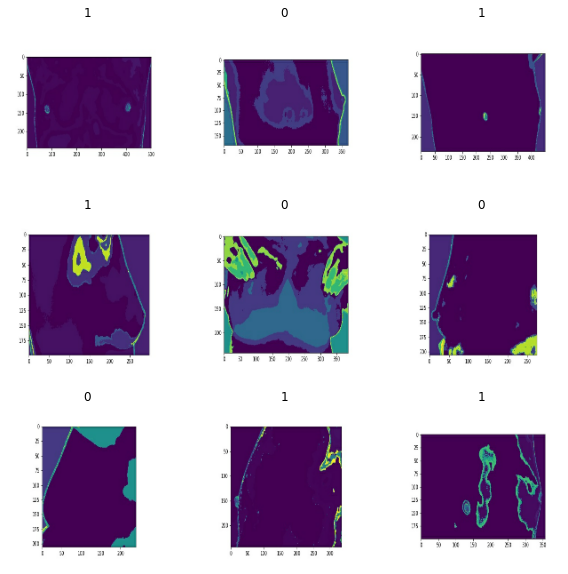

In [4]:
#Visualize the data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [5]:
#Using image data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

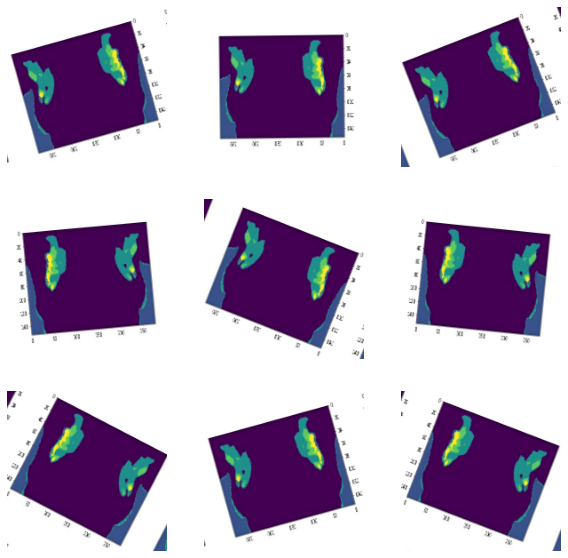

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [7]:
#Preprocess the data
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [8]:
#Configure the dataset for performance
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [9]:
#Build a model
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [10]:
#Train the model
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/25
3/3 [==============================] - 11s 3s/step - loss: 0.8016 - accuracy: 0.4048 - val_loss: 0.6919 - val_accuracy: 0.6000
Epoch 2/25
3/3 [==============================] - 9s 3s/step - loss: 0.7473 - accuracy: 0.5714 - val_loss: 0.6929 - val_accuracy: 0.6000
Epoch 3/25
3/3 [==============================] - 11s 3s/step - loss: 0.6711 - accuracy: 0.5952 - val_loss: 0.6930 - val_accuracy: 0.6000
Epoch 4/25
3/3 [==============================] - 10s 3s/step - loss: 0.6860 - accuracy: 0.6190 - val_loss: 0.6940 - val_accuracy: 0.4000
Epoch 5/25
3/3 [==============================] - 11s 3s/step - loss: 0.7035 - accuracy: 0.6071 - val_loss: 0.6972 - val_accuracy: 0.4000
Epoch 6/25
3/3 [==============================] - 10s 3s/step - loss: 0.7309 - accuracy: 0.5714 - val_loss: 0.7005 - val_accuracy: 0.4000
Epoch 7/25
3/3 [==============================] - 11s 4s/step - loss: 0.6460 - accuracy: 0.6429 - val_loss: 0.7028 - val_accuracy: 0.4000
Epoch 8/25
3/3 [===================

In [17]:
#Run inference on new data
img = keras.preprocessing.image.load_img(
    "C:/Project/Normal_Images/1.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent abnormal and %.2f percent normal."
    % (100 * (1 - score), 100 * score)
)

This image is 61.07 percent abnormal and 38.93 percent normal.


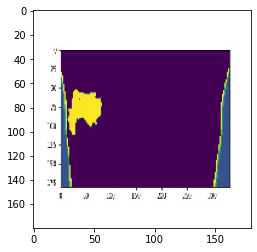

This image is 60.44 percent abnormal and 39.56 percent normal.


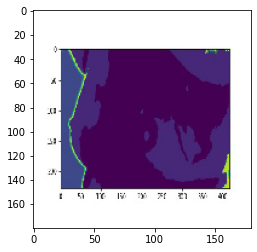

This image is 60.58 percent abnormal and 39.42 percent normal.


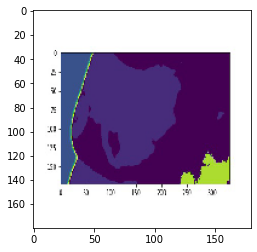

This image is 60.85 percent abnormal and 39.15 percent normal.


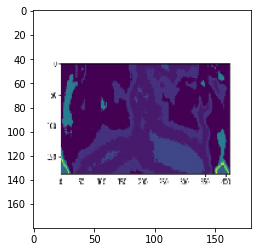

This image is 61.04 percent abnormal and 38.96 percent normal.


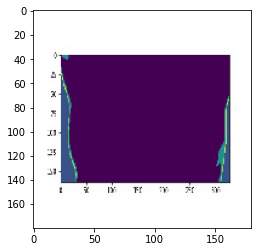

This image is 60.85 percent abnormal and 39.15 percent normal.


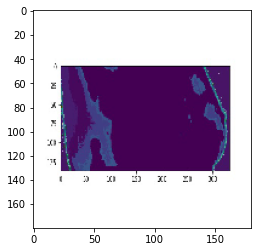

This image is 60.90 percent abnormal and 39.10 percent normal.


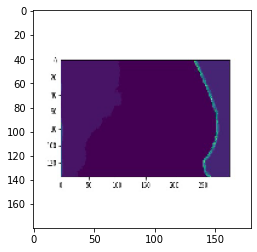

This image is 60.87 percent abnormal and 39.13 percent normal.


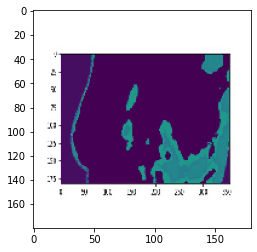

This image is 60.93 percent abnormal and 39.07 percent normal.


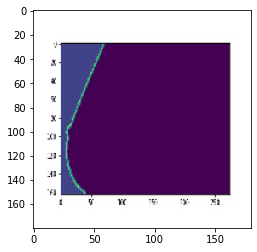

This image is 60.33 percent abnormal and 39.67 percent normal.


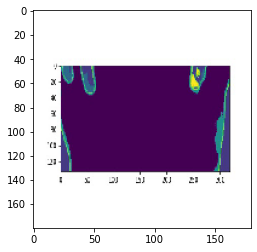

This image is 60.84 percent abnormal and 39.16 percent normal.


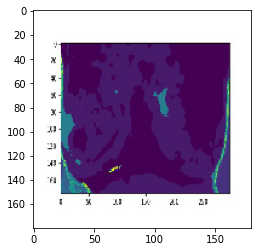

This image is 60.48 percent abnormal and 39.52 percent normal.


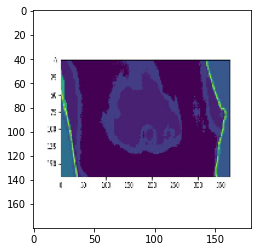

This image is 61.04 percent abnormal and 38.96 percent normal.


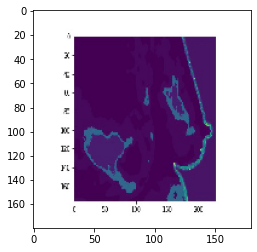

This image is 61.01 percent abnormal and 38.99 percent normal.


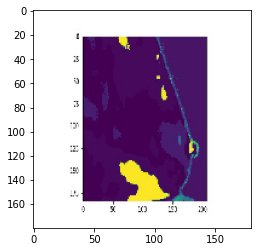

This image is 61.10 percent abnormal and 38.90 percent normal.


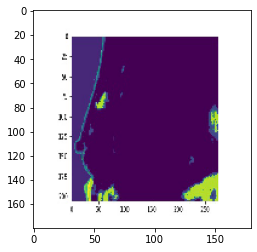

This image is 60.84 percent abnormal and 39.16 percent normal.


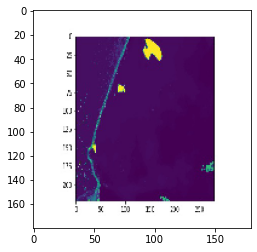

This image is 61.00 percent abnormal and 39.00 percent normal.


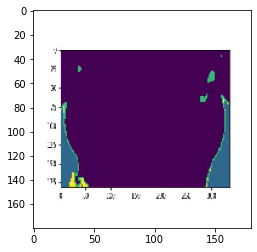

This image is 60.38 percent abnormal and 39.62 percent normal.


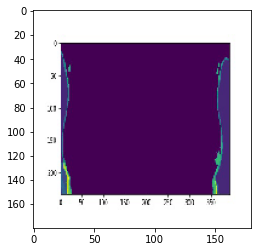

This image is 60.26 percent abnormal and 39.74 percent normal.


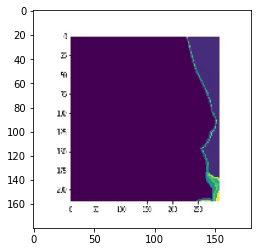

This image is 60.70 percent abnormal and 39.30 percent normal.


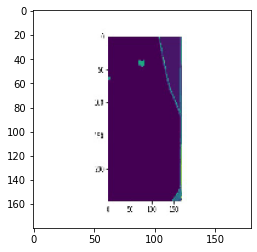

This image is 61.44 percent abnormal and 38.56 percent normal.


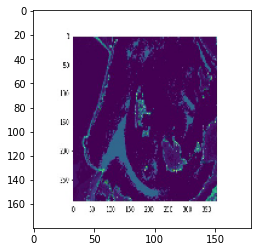

This image is 60.91 percent abnormal and 39.09 percent normal.


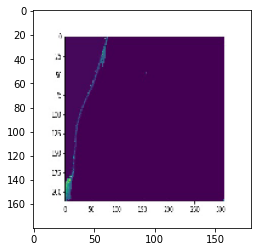

This image is 60.54 percent abnormal and 39.46 percent normal.


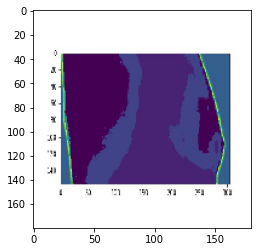

This image is 61.10 percent abnormal and 38.90 percent normal.


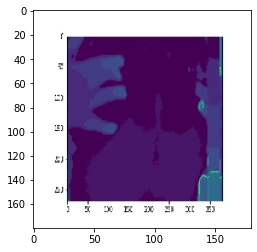

This image is 60.70 percent abnormal and 39.30 percent normal.


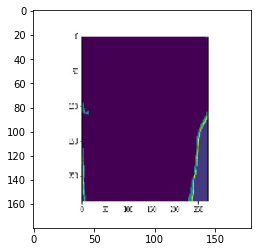

This image is 60.98 percent abnormal and 39.02 percent normal.


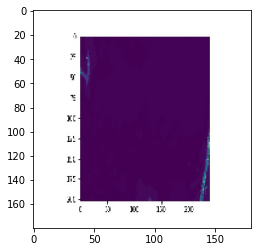

This image is 60.98 percent abnormal and 39.02 percent normal.


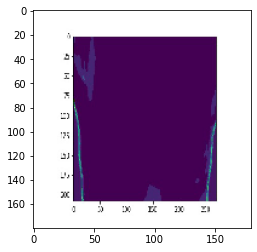

This image is 60.85 percent abnormal and 39.15 percent normal.


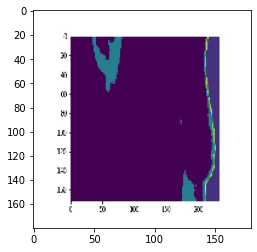

This image is 60.74 percent abnormal and 39.26 percent normal.


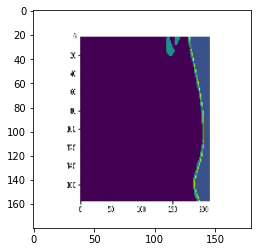

This image is 60.88 percent abnormal and 39.12 percent normal.


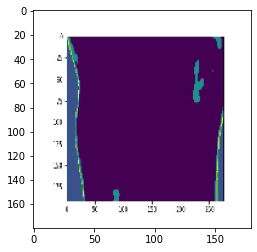

This image is 60.68 percent abnormal and 39.32 percent normal.


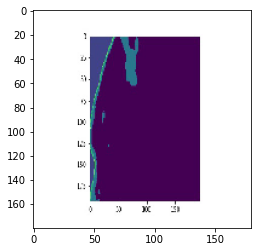

This image is 60.98 percent abnormal and 39.02 percent normal.


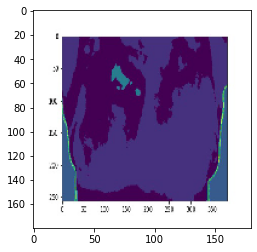

This image is 60.60 percent abnormal and 39.40 percent normal.


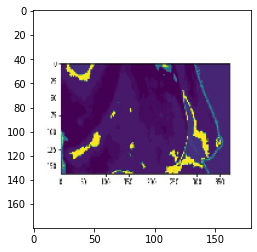

This image is 60.97 percent abnormal and 39.03 percent normal.


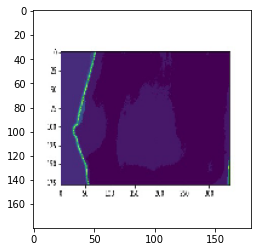

This image is 60.70 percent abnormal and 39.30 percent normal.


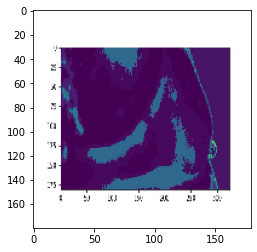

This image is 60.48 percent abnormal and 39.52 percent normal.


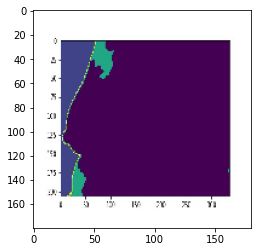

This image is 60.36 percent abnormal and 39.64 percent normal.


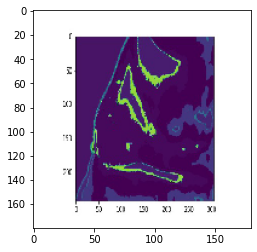

This image is 61.05 percent abnormal and 38.95 percent normal.


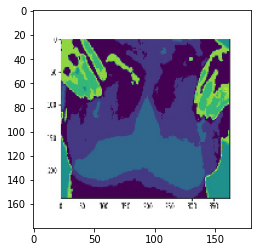

This image is 60.83 percent abnormal and 39.17 percent normal.


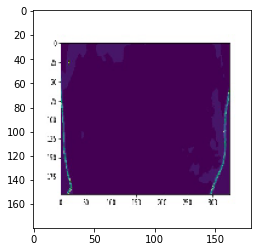

This image is 60.29 percent abnormal and 39.71 percent normal.


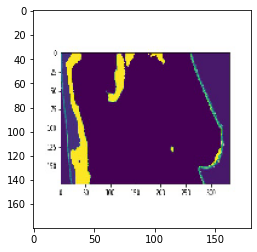

This image is 60.71 percent abnormal and 39.29 percent normal.


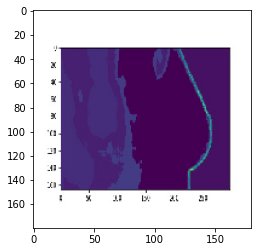

This image is 60.59 percent abnormal and 39.41 percent normal.


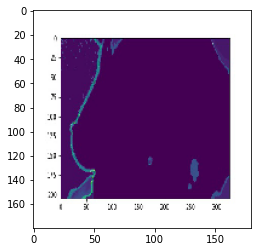

This image is 60.28 percent abnormal and 39.72 percent normal.


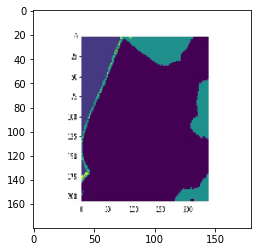

This image is 61.05 percent abnormal and 38.95 percent normal.


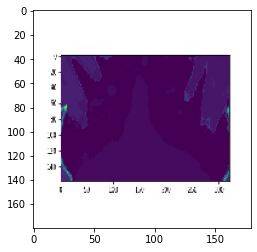

This image is 60.89 percent abnormal and 39.11 percent normal.


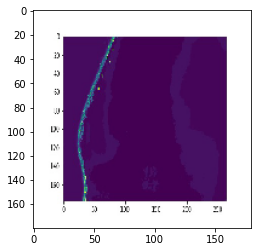

This image is 60.43 percent abnormal and 39.57 percent normal.


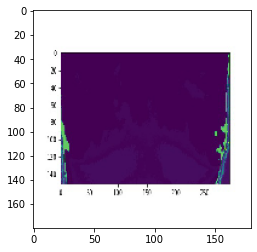

This image is 60.67 percent abnormal and 39.33 percent normal.


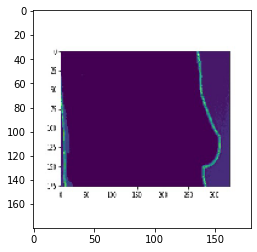

This image is 60.57 percent abnormal and 39.43 percent normal.


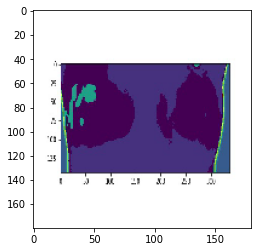

This image is 61.07 percent abnormal and 38.93 percent normal.


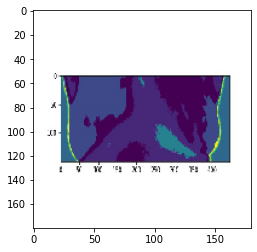

This image is 61.47 percent abnormal and 38.53 percent normal.


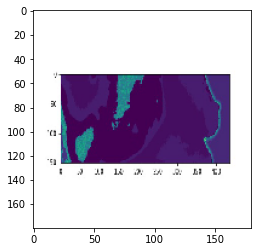

This image is 61.37 percent abnormal and 38.63 percent normal.


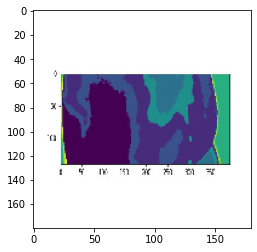

This image is 61.46 percent abnormal and 38.54 percent normal.


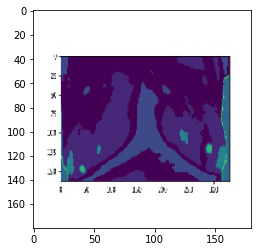

This image is 61.07 percent abnormal and 38.93 percent normal.


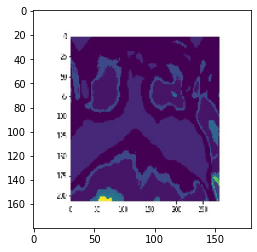

This image is 60.95 percent abnormal and 39.05 percent normal.


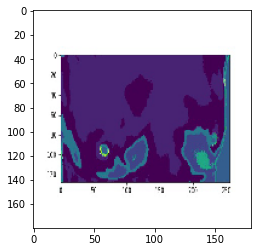

This image is 61.04 percent abnormal and 38.96 percent normal.


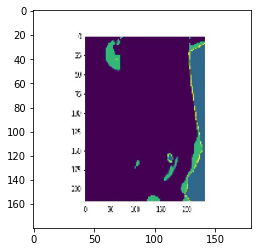

This image is 60.98 percent abnormal and 39.02 percent normal.


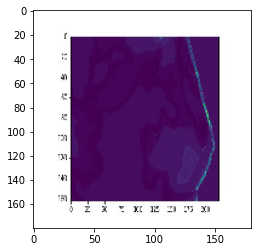

This image is 60.80 percent abnormal and 39.20 percent normal.


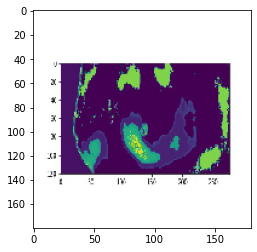

This image is 60.93 percent abnormal and 39.07 percent normal.


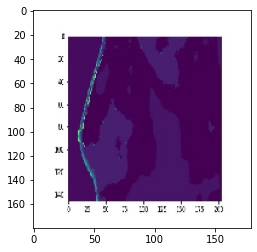

This image is 60.64 percent abnormal and 39.36 percent normal.


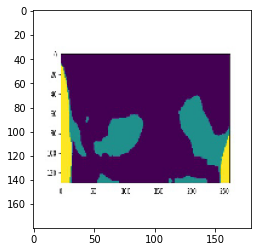

This image is 61.00 percent abnormal and 39.00 percent normal.


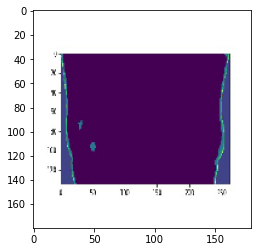

This image is 60.85 percent abnormal and 39.15 percent normal.


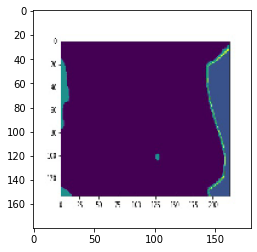

This image is 60.30 percent abnormal and 39.70 percent normal.


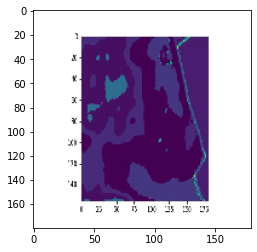

This image is 61.14 percent abnormal and 38.86 percent normal.


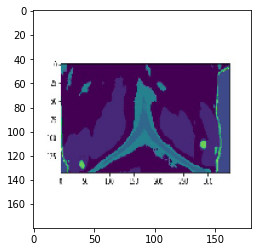

This image is 61.03 percent abnormal and 38.97 percent normal.


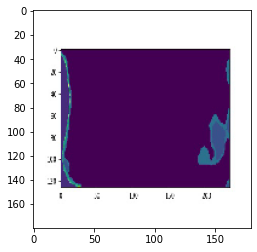

This image is 60.32 percent abnormal and 39.68 percent normal.


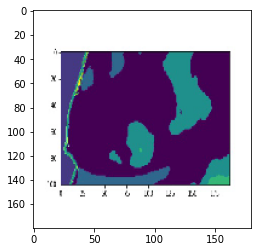

This image is 60.72 percent abnormal and 39.28 percent normal.


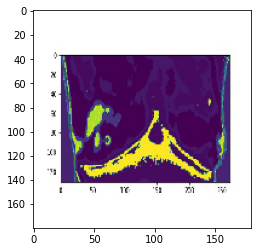

This image is 61.02 percent abnormal and 38.98 percent normal.


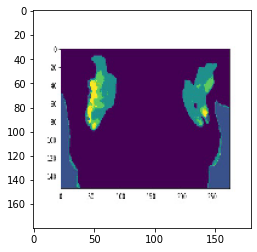

This image is 60.45 percent abnormal and 39.55 percent normal.


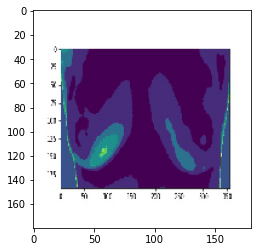

This image is 60.58 percent abnormal and 39.42 percent normal.


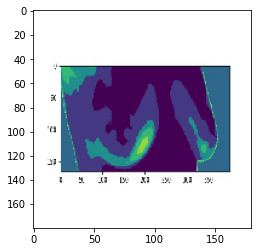

This image is 61.08 percent abnormal and 38.92 percent normal.


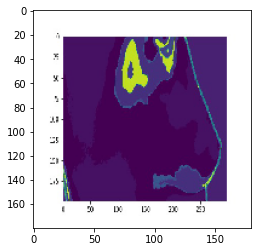

This image is 60.50 percent abnormal and 39.50 percent normal.


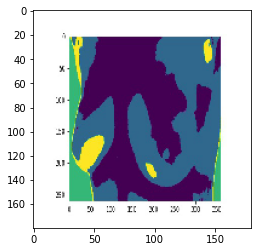

This image is 60.93 percent abnormal and 39.07 percent normal.


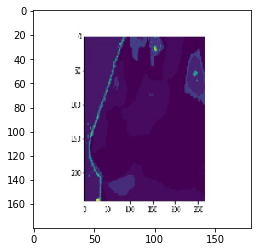

This image is 61.04 percent abnormal and 38.96 percent normal.


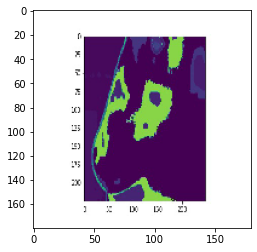

This image is 61.07 percent abnormal and 38.93 percent normal.


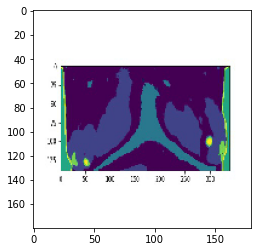

This image is 61.05 percent abnormal and 38.95 percent normal.


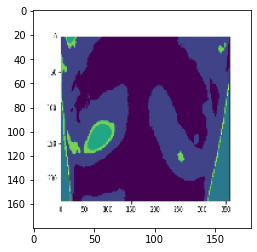

This image is 60.57 percent abnormal and 39.43 percent normal.


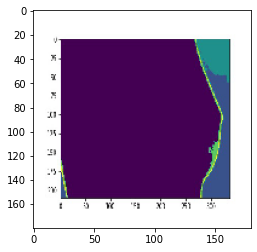

This image is 60.23 percent abnormal and 39.77 percent normal.


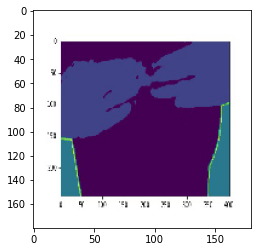

This image is 60.49 percent abnormal and 39.51 percent normal.


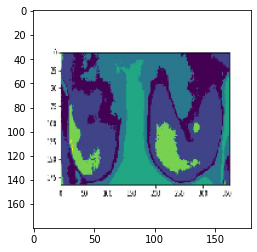

This image is 61.00 percent abnormal and 39.00 percent normal.


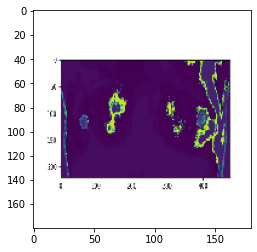

This image is 60.92 percent abnormal and 39.08 percent normal.


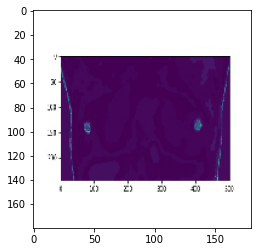

This image is 60.85 percent abnormal and 39.15 percent normal.


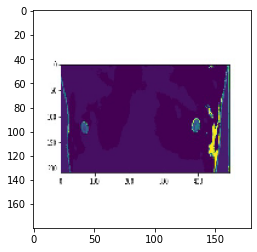

This image is 60.89 percent abnormal and 39.11 percent normal.


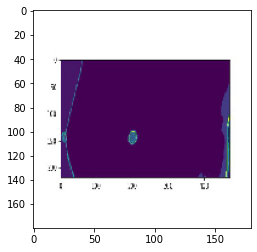

This image is 60.85 percent abnormal and 39.15 percent normal.


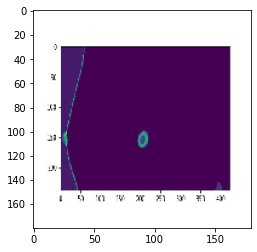

This image is 60.29 percent abnormal and 39.71 percent normal.


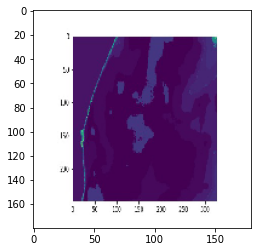

This image is 61.03 percent abnormal and 38.97 percent normal.


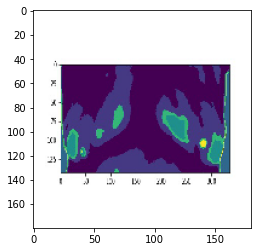

This image is 61.04 percent abnormal and 38.96 percent normal.


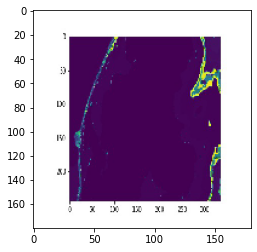

This image is 60.55 percent abnormal and 39.45 percent normal.


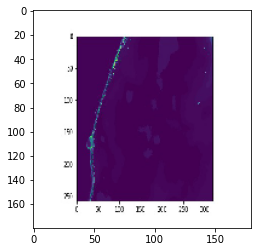

This image is 60.94 percent abnormal and 39.06 percent normal.


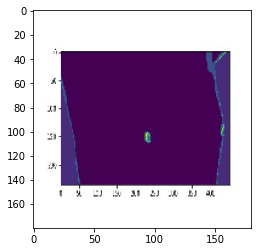

This image is 60.60 percent abnormal and 39.40 percent normal.


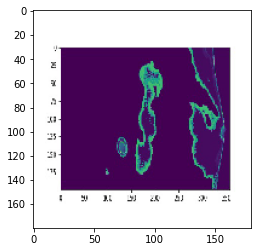

This image is 60.42 percent abnormal and 39.58 percent normal.


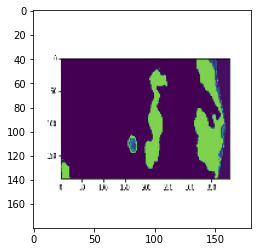

This image is 60.87 percent abnormal and 39.13 percent normal.


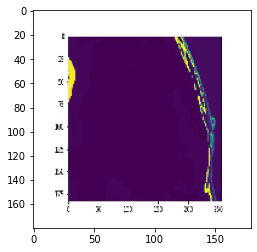

This image is 60.61 percent abnormal and 39.39 percent normal.


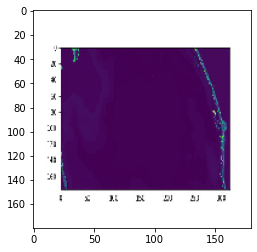

This image is 60.38 percent abnormal and 39.62 percent normal.


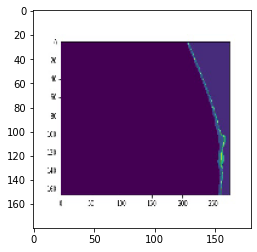

This image is 60.27 percent abnormal and 39.73 percent normal.


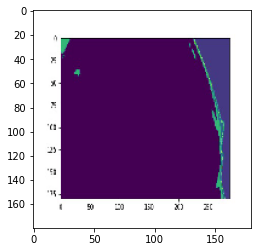

This image is 60.27 percent abnormal and 39.73 percent normal.


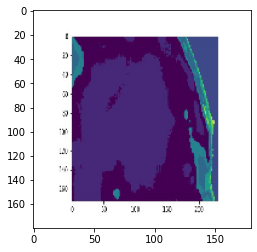

This image is 61.06 percent abnormal and 38.94 percent normal.


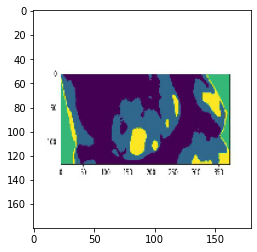

This image is 61.45 percent abnormal and 38.55 percent normal.


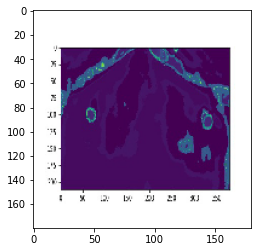

This image is 60.51 percent abnormal and 39.49 percent normal.


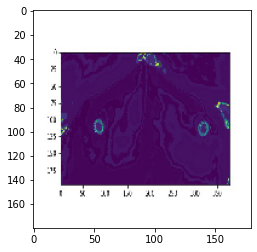

This image is 60.70 percent abnormal and 39.30 percent normal.


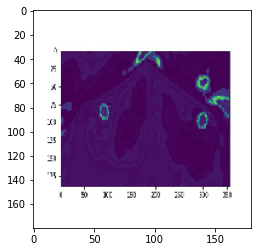

This image is 60.68 percent abnormal and 39.32 percent normal.


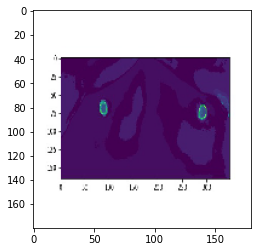

This image is 60.93 percent abnormal and 39.07 percent normal.


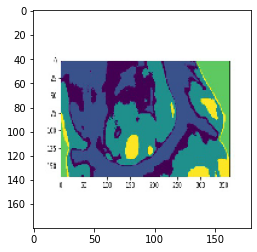

This image is 61.23 percent abnormal and 38.77 percent normal.


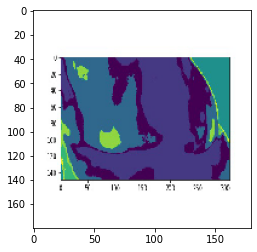

This image is 61.17 percent abnormal and 38.83 percent normal.


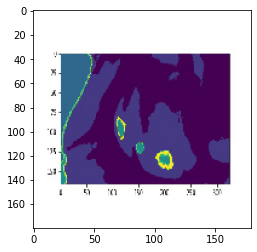

This image is 61.00 percent abnormal and 39.00 percent normal.


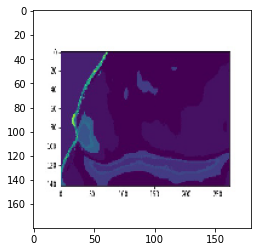

This image is 60.76 percent abnormal and 39.24 percent normal.


In [12]:
#Testing the new data
DATADIR = "C:\Project"
for folder_name in ("Abnormal_Images", "Normal_Images"):
    folder_path = os.path.join(DATADIR, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        img = keras.preprocessing.image.load_img(fpath, target_size=image_size)
        plt.imshow(img)
        plt.show()
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Create batch axis
        predictions = model.predict(img_array)
        score = predictions[0]
        print("This image is %.2f percent abnormal and %.2f percent normal." % (100 * (1 - score), 100 * score))
        

In [16]:
from tkinter import *
from tkinter import filedialog

window = Tk()
filepath = filedialog.askopenfilename(initialdir="C:\\Project\\",
                                          title="Open file okay?",
                                          filetypes=(("image files","*.jpg"),
                                          ("all files","*.*")))
window.destroy()

In [18]:
def test_gradio(image):
#     print(image.name)
    
    img = keras.preprocessing.image.load_img(filepath, target_size=image_size,)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    score = predictions[0]
    return ("This image is %.2f percent abnormal and %.2f percent normal." % (100 * (1 - score), 100 * score))


In [19]:

imagein = gr.inputs.Image(label='Upload the same image again to get prediction')
imageout =  gr.outputs.Textbox(label='Prediction Results')
gr.Interface(fn=test_gradio, inputs=imagein, outputs=imageout,title='Accuracy').launch(share=True);

Running on local URL:  http://127.0.0.1:7861/
Running on public URL: https://37807.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)
